In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import talib as ta
from pandas_datareader import data as pdr
import yfinance
from talib import MA_Type

In [2]:
# Pull Data from Yahoo Finance
stock = input("Enter your stock symble: ")
SPY = pdr.get_data_yahoo(stock, 
                          start=datetime.datetime(2006, 10, 1), 
                          end=datetime.datetime(2022, 12, 31))


# Calculate Simple Moving Average
SMA_200 = pd.DataFrame(ta.SMA(SPY['Close'], timeperiod=200))
SMA_200.rename(columns={0: "SMA"},inplace=True)

# Calculate Simple Moving Average
SMA_50 = pd.DataFrame(ta.SMA(SPY['Close'], timeperiod=50))
SMA_50.rename(columns={0: "50_SMA"},inplace=True)


# Create data frame from 2020-12-01 to current, with High, Low, Close, and SMA
result = pd.concat([SPY.loc[:,['High','Low','Close']], SMA_200], axis=1, join="inner")
result = pd.concat([result, SMA_50], axis=1, join="inner")



In [3]:
plot_begin_date = '2021-01-01'
plot_end_date = '2022-12-31'

In [4]:
# Calculate Bollinger Bands
upper, middle, lower = ta.BBANDS(SPY['Close'], matype=MA_Type.T3)

upper = pd.DataFrame(upper)
middle =pd.DataFrame(middle)
lower = pd.DataFrame(lower)

upper.rename(columns={0: "Upper"},inplace=True)
middle.rename(columns={0: "Middle"},inplace=True)
lower.rename(columns={0: "Lower"},inplace=True)

# Build dataframe with closing price and bollinger bands
result = pd.concat([result, upper], axis=1, join="inner")
result = pd.concat([result, middle], axis=1, join="inner")
result = pd.concat([result, lower], axis=1, join="inner")

<AxesSubplot:xlabel='Date'>

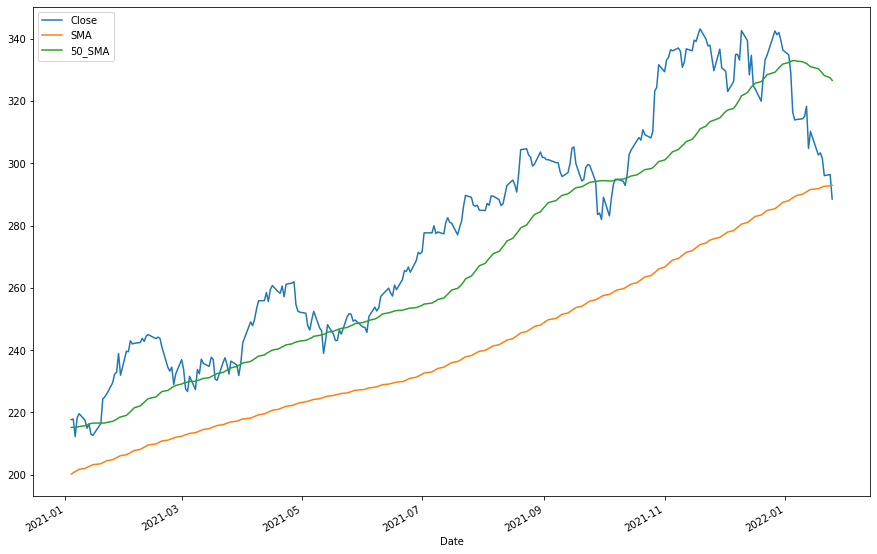

In [5]:
# Plot closing price and bollinger bands
result.loc[plot_begin_date:plot_end_date,['Close','SMA', '50_SMA']].plot(figsize=(15,10))
#result.loc[plot_begin_date:plot_end_date,['Close','SMA','Upper','Middle','Lower']].plot(figsize=(15,10))

/var/folders/4x/sh8dlvhj0sgc3drx3f_85hd00000gn/T/ipykernel_5848/2638701399.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["New Date"]= filtered.index


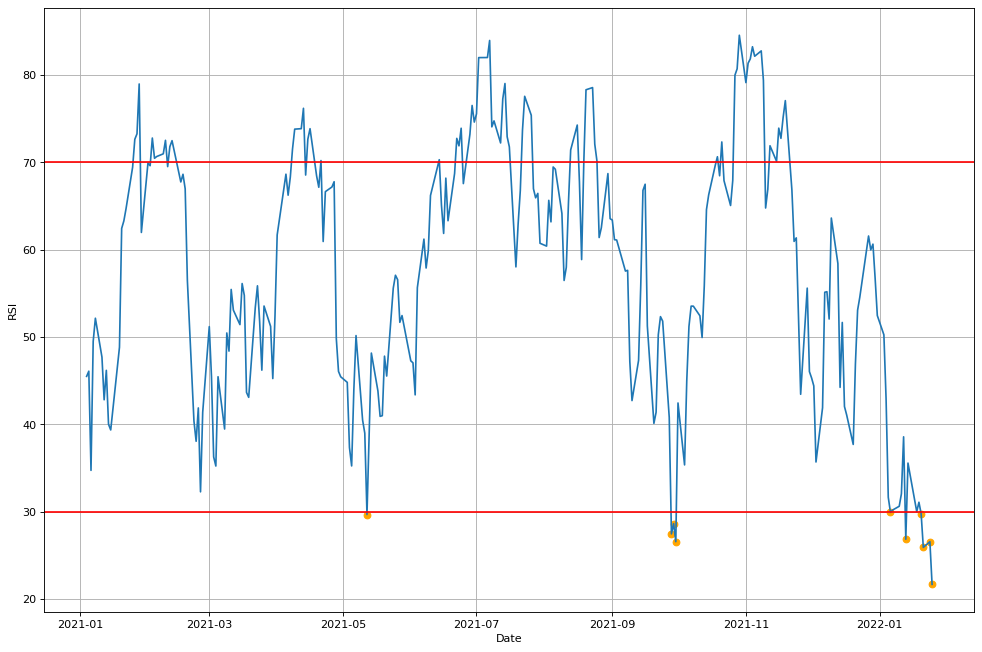

In [6]:
# Calculate RSI
RSI = ta.RSI(SPY['Close'], timeperiod=10)
RSI =pd.DataFrame(RSI)
RSI.rename(columns={0: "RSI"},inplace=True)

# Filter selection

filtered = RSI[RSI["RSI"] < 30]
filtered["New Date"]= filtered.index
filtered = filtered[filtered["New Date"] > plot_begin_date]


# Plot RSI and lines
plt.figure(figsize=(15, 10), dpi=80)
plt.xlabel('Date')
plt.ylabel('RSI')
plt.grid(True)
plt.scatter(x=filtered["New Date"],y=filtered["RSI"],c="Orange")
plt.plot(RSI.loc[plot_begin_date:plot_end_date,['RSI']])
plt.axhline(y=30, color='r', linestyle='-',label = "lower")
plt.axhline(y=70, color='r', linestyle='-',label = "upper")



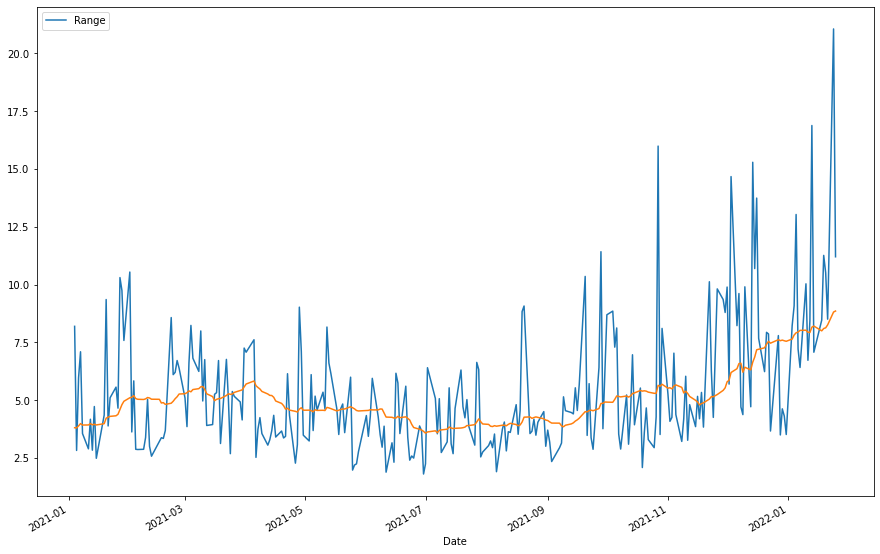

In [7]:
# Caculate True Range (Volatility)
trange = pd.DataFrame(ta.TRANGE(SPY['High'], SPY['Low'], SPY['Close']))
trange.rename(columns={0: "Range"},inplace=True)

# Caculate Moving Average of True Range as TR MA
trange_ma = pd.DataFrame(ta.SMA(trange['Range']))
trange_ma.rename(columns={0: "TR MA"},inplace=True)

# Plot True Range and TR MA
bx = trange.loc[plot_begin_date:plot_end_date,['Range']].plot(figsize=(15,10))
bx.plot(trange_ma.loc[plot_begin_date:plot_end_date,['TR MA']])

#  Add true range and true range MA into result
result = pd.concat([trange_ma, result], axis=1, join="inner")
result = pd.concat([trange, result], axis=1, join="inner")

# Calculate Volatility
result['vol_%'] = (result['Range']/result['Close'])*100

# Caculate flag with if/else
result['flag']= np.where(result['Range']>5, 1, 0)

#bx.plot(result.loc["2020-12-01":"2022-12-31",['vol_%']])